<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/caltech101_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 102
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 9

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/caltech101_pickle'
image_size = (128, 128)
input_shape = (128, 128, 3)
num_classes = 102

In [ ]:
import gzip
import pickle

os.chdir(path)

with gzip.open('caltech101_x_trainData_128.pickle', 'rb') as f:
    x_train = pickle.load(f)
    
with gzip.open('caltech101_x_testData_128.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with gzip.open('caltech101_y_trainData_128.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with gzip.open('caltech101_y_testData_128.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
# convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet56v1
x_train shape: (7316, 128, 128, 3)
7316 train samples
1829 test samples
y_train shape: (7316, 102)


In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=num_classes):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['acc'])
model.summary()

# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 128, 128, 16) 64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 128, 128, 16) 0           batch_normalization_55[0][0]     
______________________________________________________________________

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]
#callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

Using real-time data augmentation.


In [ ]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)


# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/100
Learning rate:  0.001
229/229 [==============================] - 81s 314ms/step - loss: 4.6386 - acc: 0.2295 - val_loss: 4.1557 - val_acc: 0.2061
Epoch 2/100
Learning rate:  0.001
229/229 [==============================] - 72s 314ms/step - loss: 3.4529 - acc: 0.3403 - val_loss: 3.1888 - val_acc: 0.3953
Epoch 3/100
Learning rate:  0.001
229/229 [==============================] - 72s 315ms/step - loss: 2.9957 - acc: 0.4076 - val_loss: 3.0022 - val_acc: 0.4204
Epoch 4/100
Learning rate:  0.001
229/229 [==============================] - 72s 315ms/step - loss: 2.6473 - acc: 0.4691 - val_loss: 6.3543 - val_acc: 0.3341
Epoch 5/100
Learning rate:  0.001
229/229 [==============================] - 72s 315ms/step - loss: 2.3753 - acc: 0.5198 - val_loss: 2.3350 - val_acc: 0.5451
Epoch 6/100
Learning rate:  0.001
229/229 [==============================] - 72s 315ms/step - loss: 2.2002 - acc: 0.5500 - val_loss: 2.1537 - val_acc: 0.5692
Epoch 7/100
Learning rate:  0.001
229/229 [=========

In [ ]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

58/58 [==============================] - 4s 76ms/step - loss: 1.5088 - acc: 0.7654


[1.5088434219360352, 0.7654455900192261]

In [ ]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[6.4230405e-02 1.1920930e-07 1.1920930e-07 ... 4.3747479e-01 1.1424823e-01
 6.4567733e-01]


In [ ]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [ ]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

1400
429


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

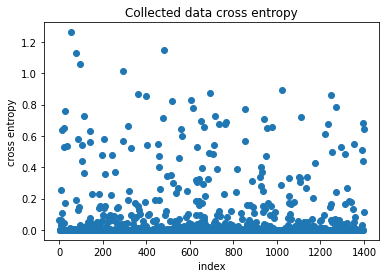

In [ ]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(x_value, collect_Cce)
plt.title('Collected data cross entropy')
plt.xlabel('index')
plt.ylabel('cross entropy')
plt.show()

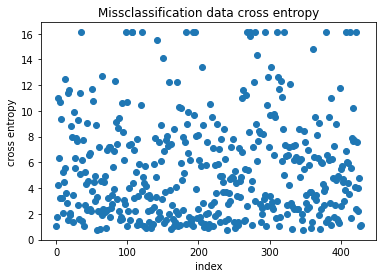

In [ ]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(X_value, missclassification_Cce)
plt.title('Missclassification data cross entropy')
plt.xlabel('index')
plt.ylabel('cross entropy')
plt.show()

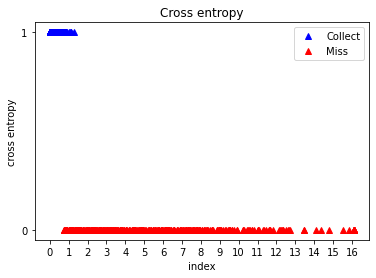

In [ ]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.xlabel('index')
plt.ylabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [ ]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.2613289
0.74587244


In [ ]:
def static_Threshold() :
  threshold = []
  for i in range(1, 10):
    threshold.append(round(i * 0.1, 1))
  return threshold

In [ ]:
staticThreshold = static_Threshold()
print(staticThreshold)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [ ]:
def dynamic_Threshold(missclassification_Cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [1.645, 1.96, 2.326] # 95%, 97.5%, 99% one-tails
  threshold = [min(missclassification_Cce)]
  x_ = np.mean(missclassification_Cce)
  o = np.std(missclassification_Cce)
  n_ = (len(missclassification_Cce))**0.5

  for z in Z :
    threshold.append(x_- (z * o)/n_)
  
  return threshold

In [ ]:
dynamicThreshold = dynamic_Threshold(missclassification_Cce)
print(dynamicThreshold)

[0.74587244, 5.185324421156891, 5.125026945426301, 5.054967021244092]


In [ ]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [ ]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [ ]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

In [ ]:
print(len(PMD_By_Static_Threshold))
print(PMD_By_Static_Threshold)
print(len(PMD_By_Dynamic_Threshold))
print(PMD_By_Dynamic_Threshold)

9
[[6, 12, 13, 26, 28, 31, 32, 41, 64, 94, 96, 111, 112, 118, 120, 131, 137, 146, 149, 182, 184, 198, 239, 241, 242, 256, 267, 270, 274, 276, 308, 316, 330, 345, 352, 376, 377, 403, 404, 409, 422, 445, 458, 461, 465, 471, 501, 504, 513, 527, 559, 580, 581, 583, 585, 590, 612, 615, 629, 631, 662, 665, 671, 687, 700, 706, 723, 730, 758, 763, 778, 792, 805, 810, 812, 814, 823, 826, 829, 840, 844, 850, 851, 860, 871, 891, 892, 903, 918, 927, 929, 940, 951, 955, 988, 992, 998, 1032, 1062, 1071, 1097, 1117, 1121, 1131, 1147, 1155, 1164, 1172, 1209, 1210, 1212, 1220, 1221, 1224, 1227, 1228, 1237, 1238, 1242, 1253, 1269, 1272, 1291, 1326, 1332, 1369, 1370, 1371, 1375, 1384, 1400, 1430, 1436, 1437, 1442, 1472, 1481, 1513, 1528, 1590, 1609, 1619, 1625, 1627, 1632, 1659, 1664, 1690, 1713, 1714, 1730, 1739, 1747, 1762, 1772, 1816, 1824, 1826, 1827, 1828], [6, 12, 26, 28, 31, 41, 64, 94, 111, 120, 131, 137, 146, 149, 182, 184, 198, 241, 256, 267, 274, 308, 316, 330, 376, 377, 403, 409, 422, 458, 50

In [ ]:
import cv2

In [ ]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((64, 64), angle, 1)
    new_img = cv2.warpAffine(img, m, (128, 128), cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [ ]:
def img_trim(img, size) :
  w = 128
  h = 128
  new_img = img[size:size+h, size:size+w]
  return new_img

In [ ]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(128*rate/2 - 64)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(64 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, (128, 128), interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [ ]:
def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  return MD

In [ ]:
def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  return cnt/len(PMD)

In [ ]:
def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  return cnt/len(MD)

In [ ]:
def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  new_y_pred = model.predict(data_set) # error
  MD = get_MD(y_pred, new_y_pred, y_test)

  for s in PMD_By_Static_Threshold :
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))

  for d in PMD_By_Dynamic_Threshold :
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))

  return Stp, Dtp, Str, Dtr

In [ ]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [ ]:
def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

In [ ]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)

In [ ]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [ ]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
rotate 20degree
rotate 30degree
rotate 40degree
rotate 50degree
rotate 60degree
rotate 70degree
rotate 80degree
rotate 90degree


In [ ]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
augmentation 1.2%
augmentation 1.3%
augmentation 1.4%


In [ ]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
reduction 0.8%
reduction 0.7%
reduction 0.6%


In [ ]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.7840277777777778, 0.7989898989898989, 0.8039950062421971, 0.8218954248366013, 0.8477366255144033, 0.8333333333333333, 0.8677248677248678, 0.8333333333333335, 0.8444444444444444]
[0.183358719945324, 0.1325836305577468, 0.10847642889693401, 0.08444624927574178, 0.07034201720697959, 0.04809779510363152, 0.02478384169450232, 0.013185722184296948, 0.005818265008916606]
[0.74587244, 5.185324421156891, 5.125026945426301, 5.054967021244092]
[0.8472222222222222, 0.0, 0.0, 0.0]
[0.018291660620597158, 0.0, 0.0, 0.0]


In [ ]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.39375000000000004, 0.4477272727272727, 0.4662921348314607, 0.4963235294117647, 0.4722222222222222, 0.4671052631578947, 0.5714285714285714, 0.7083333333333334, 0.9]
[0.35451279360478627, 0.28908237232726164, 0.24726672986094317, 0.20444495831472514, 0.1497887493005382, 0.1022022528700734, 0.07149753518785587, 0.05126771749216397, 0.02697646130880407]
[0.74587244, 5.185324421156891, 5.125026945426301, 5.054967021244092]
[0.578125, 0.0, 0.0, 0.0]
[0.05463598272689776, 0.0, 0.0, 0.0]


In [ ]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.5734375, 0.6159090909090909, 0.6292134831460674, 0.6580882352941176, 0.7083333333333334, 0.7171052631578947, 0.7857142857142858, 0.7708333333333334, 0.7]
[0.48264163146759165, 0.3649867974867174, 0.3038977159880834, 0.252696333041978, 0.2187207977338355, 0.1574900809540589, 0.09923259914851035, 0.05423563473504211, 0.019041250417583824]
[0.74587244, 5.185324421156891, 5.125026945426301, 5.054967021244092]
[0.75, 0.0, 0.0, 0.0]
[0.0716135286481572, 0.0, 0.0, 0.0]
